In [1]:
from keras.applications.vgg19 import VGG19
#Importa as bibliotecas para plotar os filtros
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import decode_predictions

#Carrega o modelo ja treinado
model = VGG19()

Using TensorFlow backend.
/home/gustavo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gustavo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gustavo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gustavo/.local/lib/python3.6/site-packages/tensorflow/py

Instructions for updating:
Colocations handled automatically by placer.


In [2]:
#model.summary()

In [3]:
j=0
for i in model.layers[1:]:
    print(j, ' ', i.name, " - ", i.output_shape)
    j+=1

0   block1_conv1  -  (None, 224, 224, 64)
1   block1_conv2  -  (None, 224, 224, 64)
2   block1_pool  -  (None, 112, 112, 64)
3   block2_conv1  -  (None, 112, 112, 128)
4   block2_conv2  -  (None, 112, 112, 128)
5   block2_pool  -  (None, 56, 56, 128)
6   block3_conv1  -  (None, 56, 56, 256)
7   block3_conv2  -  (None, 56, 56, 256)
8   block3_conv3  -  (None, 56, 56, 256)
9   block3_conv4  -  (None, 56, 56, 256)
10   block3_pool  -  (None, 28, 28, 256)
11   block4_conv1  -  (None, 28, 28, 512)
12   block4_conv2  -  (None, 28, 28, 512)
13   block4_conv3  -  (None, 28, 28, 512)
14   block4_conv4  -  (None, 28, 28, 512)
15   block4_pool  -  (None, 14, 14, 512)
16   block5_conv1  -  (None, 14, 14, 512)
17   block5_conv2  -  (None, 14, 14, 512)
18   block5_conv3  -  (None, 14, 14, 512)
19   block5_conv4  -  (None, 14, 14, 512)
20   block5_pool  -  (None, 7, 7, 512)
21   flatten  -  (None, 25088)
22   fc1  -  (None, 4096)
23   fc2  -  (None, 4096)
24   predictions  -  (None, 1000)


In [4]:
# Import Independent Component Analysis Algorithm
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#--------------------------------------------------------------------------------------------------
def dimRed(patterns, num_comp, pca = 1):
    maps = []
    # Initialize the algorithm and set the number of PC's
    if(pca == 0) :
        dim_red = FastICA(n_components=num_comp)
    else:
        dim_red = PCA(n_components=num_comp)

    # Fit and transform the model to data. It returns a list of independent components 
    for aux in patterns:
        aux = dim_red.fit_transform(aux)

        f_min, f_max = np.amin(aux), np.amax(aux)
        aux = (aux - f_min) / (f_max - f_min)
        
        maps.append(aux)
    print(len(maps[0]), 'x', len(maps[0][0]))
    return maps
#------------------------------------------------------------------------------------------------
def Pooling(patterns, typ = 'max'):
    patterns_N =[]
    for pat_aux in patterns:
        red_patterns = np.empty((int(pat_aux.shape[0]/2), int(pat_aux.shape[1]/2)))
        l=0
        for i in range(0, pat_aux.shape[0], 2):
            c=0
            for j in range(0, pat_aux.shape[1], 2):
                if(typ == 'max'):
                    red_patterns[l][c] = max(pat_aux[i][j], pat_aux[i+1][j], pat_aux[i][j+1], pat_aux[i+1][j+1])
                else:
                    red_patterns[l][c] = (pat_aux[i][j] + pat_aux[i+1][j] + pat_aux[i][j+1] + pat_aux[i+1][j+1])/4
                c+=1
            l+=1
        patterns_N.append(red_patterns)
    print(len(red_patterns), 'x', len(red_patterns[0]))
    return patterns_N
#-----------------------------------------------------------------------------------------------
def invPooling(patterns):
    patterns_N =[]
    for pat_aux in patterns:
        red_patterns = np.empty((int(pat_aux.shape[0]*2), int(pat_aux.shape[1]*2)))
        l=0
        for i in range(0, pat_aux.shape[0], 1):
            c=0
            for j in range(0, pat_aux.shape[1], 1):
                red_patterns[l][c] = pat_aux[i][j];
                red_patterns[l+1][c] = pat_aux[i][j];
                red_patterns[l][c+1] = pat_aux[i][j];
                red_patterns[l+1][c+1] = pat_aux[i][j];
                c+=2
            l+=2
        patterns_N.append(red_patterns)
    print(len(red_patterns), 'x', len(red_patterns[0]))
    return patterns_N
#----------------------------------------------------------------------------------------------
def printPatterns(patterns, tittles, prob):
    j=1
    for i in range(len(patterns)):
        to_plot = patterns[i]
        plt.subplot(len(patterns), 11, j)
        plt.imshow(to_plot, cmap='hot')
        j+=1
        plt.title(tittles[i]+' - '+prob[i]+'%')
    plt.subplots_adjust(left=0, bottom=0, right=5, top=25, wspace=0.2, hspace=0.2)
    plt.show()
#---------------------------------------------------------------------------------------------    
def printMaps(maps, tittles, prob, l, c):
    j=1
    for i in range(len(maps)):
        to_plot = maps[i]
        to_plot = to_plot.reshape((l, c))
        plt.subplot(len(maps), 6, j)
        plt.imshow(to_plot, cmap='hot')
        j+=1
        plt.title(tittles[i]+' - '+prob[i]+'%')
    plt.subplots_adjust(left=0, bottom=0, right=3, top=15, wspace=0.2, hspace=0.05)
    plt.show()

In [5]:
layer_outputs = [layer.output for layer in model.layers[1:] ]
# Extracts the outputs of the top 12 layers
from keras import models
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
# Creates a model that will return these outputs, given the model input

In [6]:
imgs = ('elephant1.jpeg', 'elephant2.jpeg', 'elephant3.jpeg', 'elephant4.jpeg', 'plumbus.webp', 'plumbus2.jpeg', 'pneu.jpeg', 'pneu2.jpeg', 
        'caneca1.jpg', 'caneca2.jpeg', 'caneca3.jpg', 'caneca4.jpeg', 'deer.jpg', 'deer2.jpeg', 'impala.jpeg', 'deer3.jpeg', 'aviao1.jpeg', 
        'aviao2.jpeg', 'car1.jpeg', 'car2.jpeg', 'esquilo1.jpeg', 'esquilo2.jpeg', 'rato1.jpeg', 'rato2.jpeg', 'pessoa1.jpeg', 'pessoa2.jpeg',
       'sand1.jpeg', 'sand2.jpeg', 'girafa1.jpeg', 'girafa2.jpeg', 'girafa3.jpeg', 'girafa4.jpeg', 'girafa5.jpeg', 'girafa6.jpeg', 'girafa7.jpeg', 
        'zeb_gir.jpeg', 'mesa_comp.jpg', 'passaro1.jpeg', 'polvo1.jpg', 'polvo2.jpg', 'passaro_comp.png', 'cena.jpeg', 'plateia.jpg', 'A.jpeg',
       'dogs.jpeg', 'dogs2.jpeg')

In [26]:
layer = 15
layer_2 = 20
img_plot = []
patterns = []
patterns_red = []
tittles = []
prob = []
for i in imgs:
    img_aux = load_img('/home/gustavo/PROG/images/'+i, target_size=(224, 224))
    img_aux = img_to_array(img_aux)
    img_plot.append(img_aux)
    img_aux = img_aux.reshape((1, img_aux.shape[0], img_aux.shape[1], img_aux.shape[2]))
    #img_aux = preprocess_input(img_aux)
    
    acts = activation_model.predict(img_aux)
    pred_aux = acts[layer]
    pred_aux_2 = acts[layer_2]
    f_min, f_max = np.amin(pred_aux), np.amax(pred_aux)
    f_min_2, f_max_2 = np.amin(pred_aux_2), np.amax(pred_aux_2)
    pred_aux = (pred_aux - f_min) / (f_max - f_min)
    pred_aux_2 = (pred_aux_2 - f_min_2) / (f_max_2 - f_min_2)
    
    patterns.append(pred_aux[0].reshape((392,256)))
    patterns_red.append(pred_aux_2[0].reshape((196,128)))
    
    label = model.predict(img_aux)
    label = decode_predictions(label)
    label = label[0][0]
    tittles.append(label[1])
    prob.append(str(int(label[2]*100)))

In [27]:
#printPatterns(patterns, tittles, prob)
maps_1 = dimRed(patterns, 1)
maps_red_1 = dimRed(patterns_red, 1)
print("---------------------------------")
#printMaps(maps_1, tittles, prob, 14, 28)
patterns_2 = Pooling(patterns)
patterns_red_2 = Pooling(patterns_red)
print("---------------------------------")
#printPatterns(patterns_2, tittles, prob)
maps_2 = dimRed(patterns_2, 1)
maps_red_2 = dimRed(patterns_red_2, 1)
print("---------------------------------")
#printMaps(maps_2, tittles, prob, 14, 14)
patterns_3 = Pooling(patterns_2)
patterns_red_3 = Pooling(patterns_red_2)
print("---------------------------------")
#printPatterns(patterns_3, tittles, prob)
maps_3 = dimRed(patterns_3, 1, 1)
maps_red_3 = dimRed(patterns_red_3, 1, 1)
print("---------------------------------")
#printMaps(maps_3, tittles, prob, 14, 7)

392 x 1
196 x 1
---------------------------------
196 x 128
98 x 64
---------------------------------
196 x 1
98 x 1
---------------------------------
98 x 64
49 x 32
---------------------------------
98 x 1
49 x 1
---------------------------------


In [28]:
maps_img = []
for aux in maps_2:
    maps_img.append(aux.reshape((14, 14)))
for i in range(4):
    maps_img = invPooling(maps_img)
    
maps_red_img = []
for aux in maps_red_3:
    maps_red_img.append(aux.reshape((7, 7)))
for i in range(5):
    maps_red_img = invPooling(maps_red_img)
    

28 x 28
56 x 56
112 x 112
224 x 224
14 x 14
28 x 28
56 x 56
112 x 112
224 x 224


In [29]:
filtros_ref = []
for i in range(len(maps_img)):
    aux = (0.2*maps_img[i]+0.8*maps_red_img[i])*maps_img[i]
    f_min, f_max = np.amin(aux), np.amax(aux)
    aux = (aux - f_min) / (f_max - f_min)
    filtros_ref.append(aux)

In [30]:
maps_input = filtros_ref
for i in range(4):
    maps_input = Pooling(maps_input)

112 x 112
56 x 56
28 x 28
14 x 14


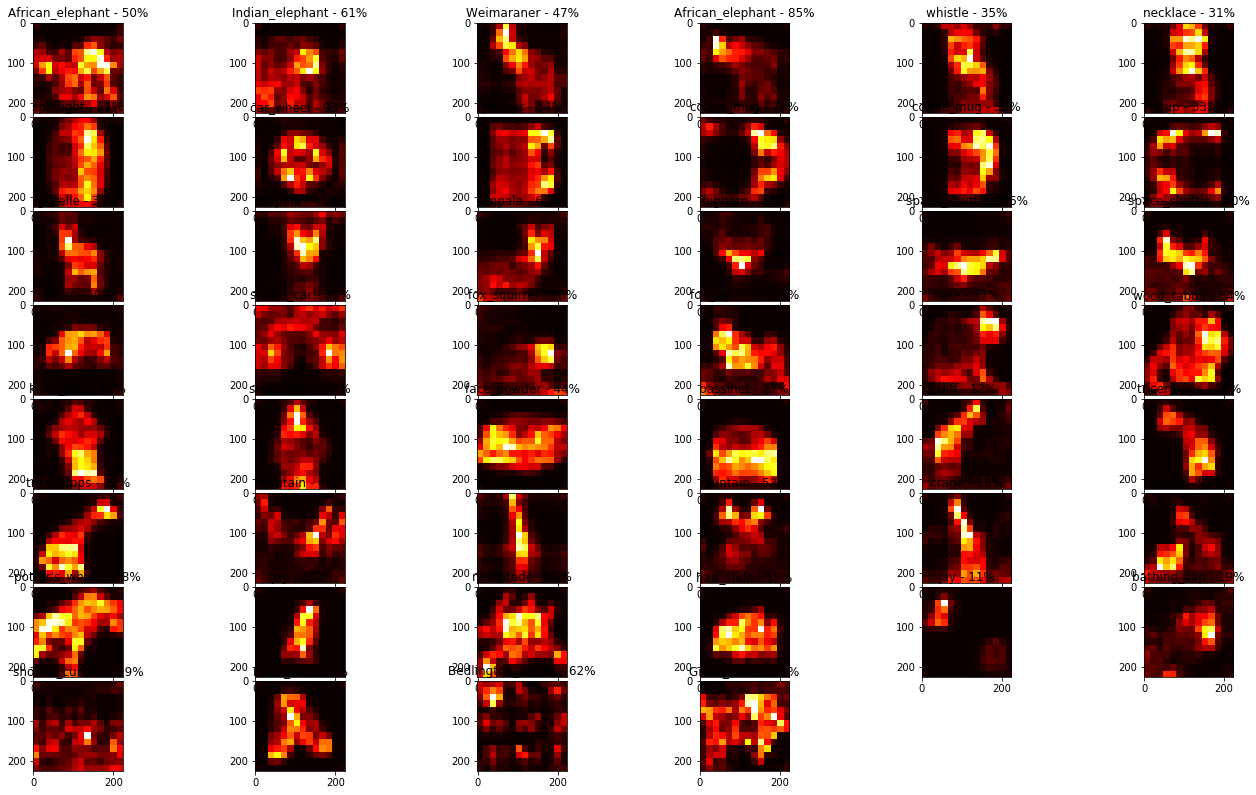

In [31]:
printMaps(filtros_ref, tittles, prob, 224, 224)
som_input = []
som_input_red = []

for i in patterns_red_3:
    som_input_red.append(i.reshape((len(i)*len(i[0]))))
size_red = len(i)*len(i[0])

25088
400


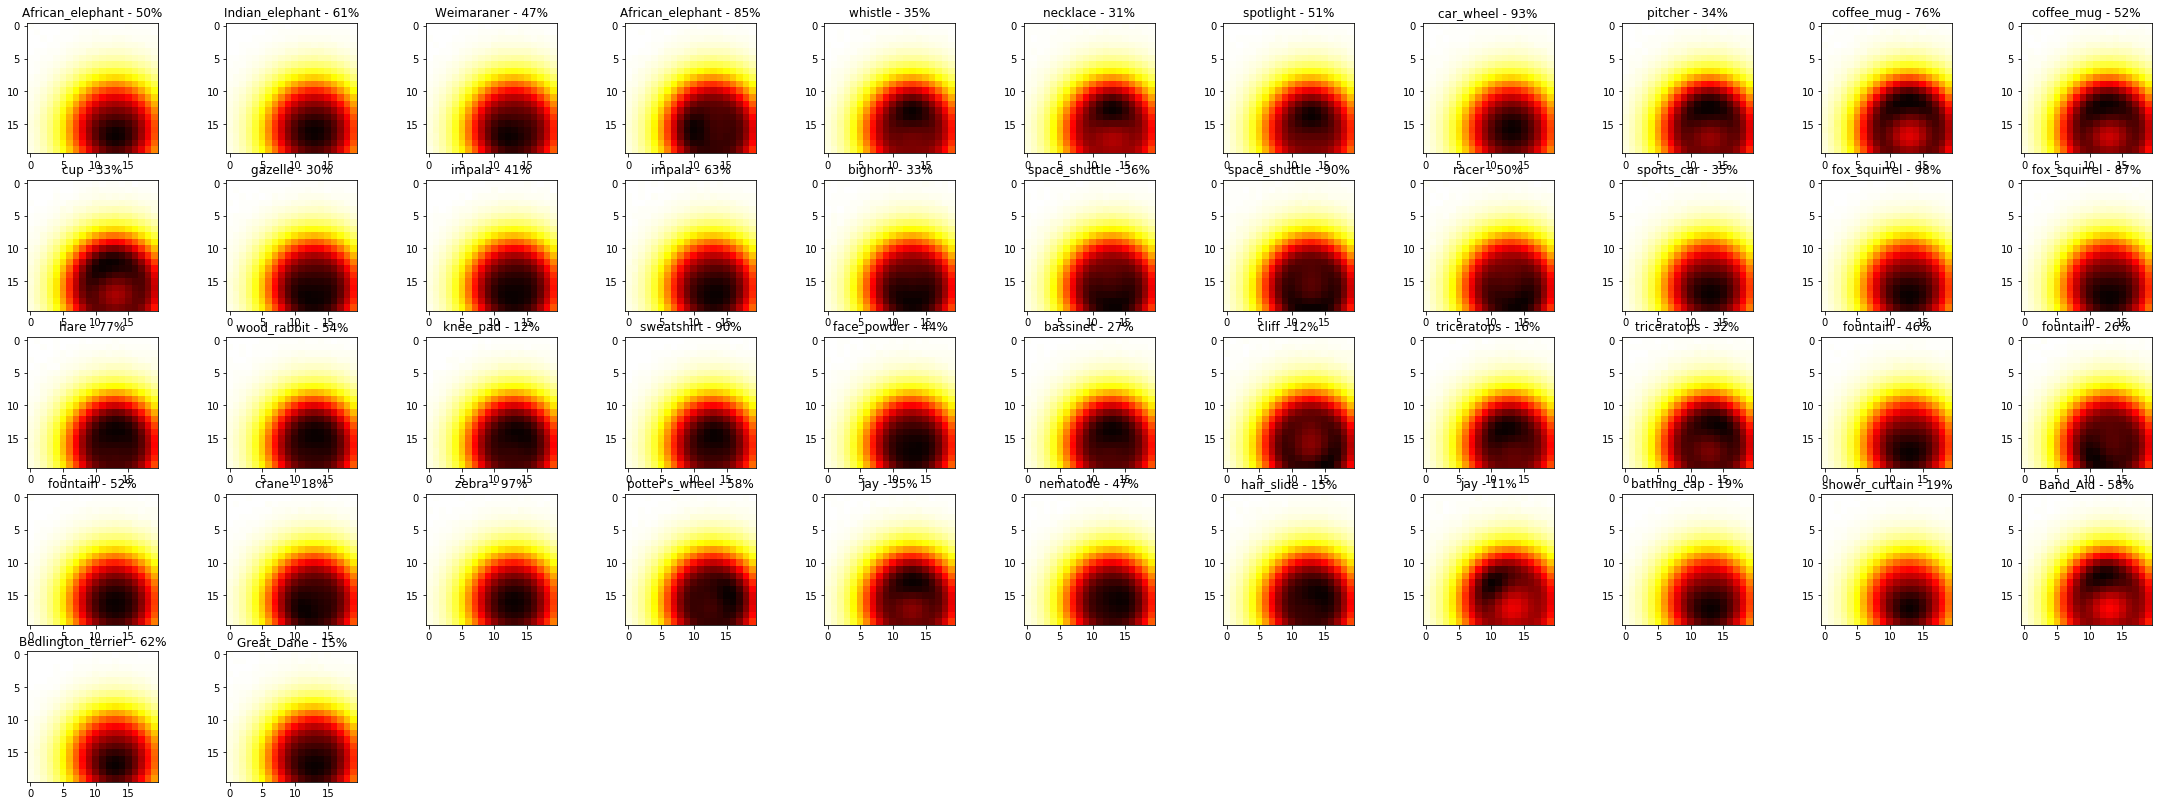

In [32]:
from minisom import MiniSom

for i in patterns_2:
    som_input.append(i.reshape((len(i)*len(i[0]))))
size = len(i)*len(i[0])
print(size)

dim = 20
som = MiniSom(dim, dim, size, sigma=3, learning_rate=0.05)
som.train(som_input, 100)

locations = []
for aux in som_input:
    locations.append(som.activate(aux))

for i in range(len(locations)):
    f_min, f_max = np.amin(locations[i]), np.amax(locations[i])
    locations[i] = (locations[i] - f_min) / (f_max - f_min)
    #locations[i] = 1-locations[i]
   
    #for j in range(dim):
        #for k in range(dim):
            #if(locations[i][j][k] < 0.7): locations[i][j][k] = 0
                
print(dim*dim)
printPatterns(locations, tittles, prob)

25088
400


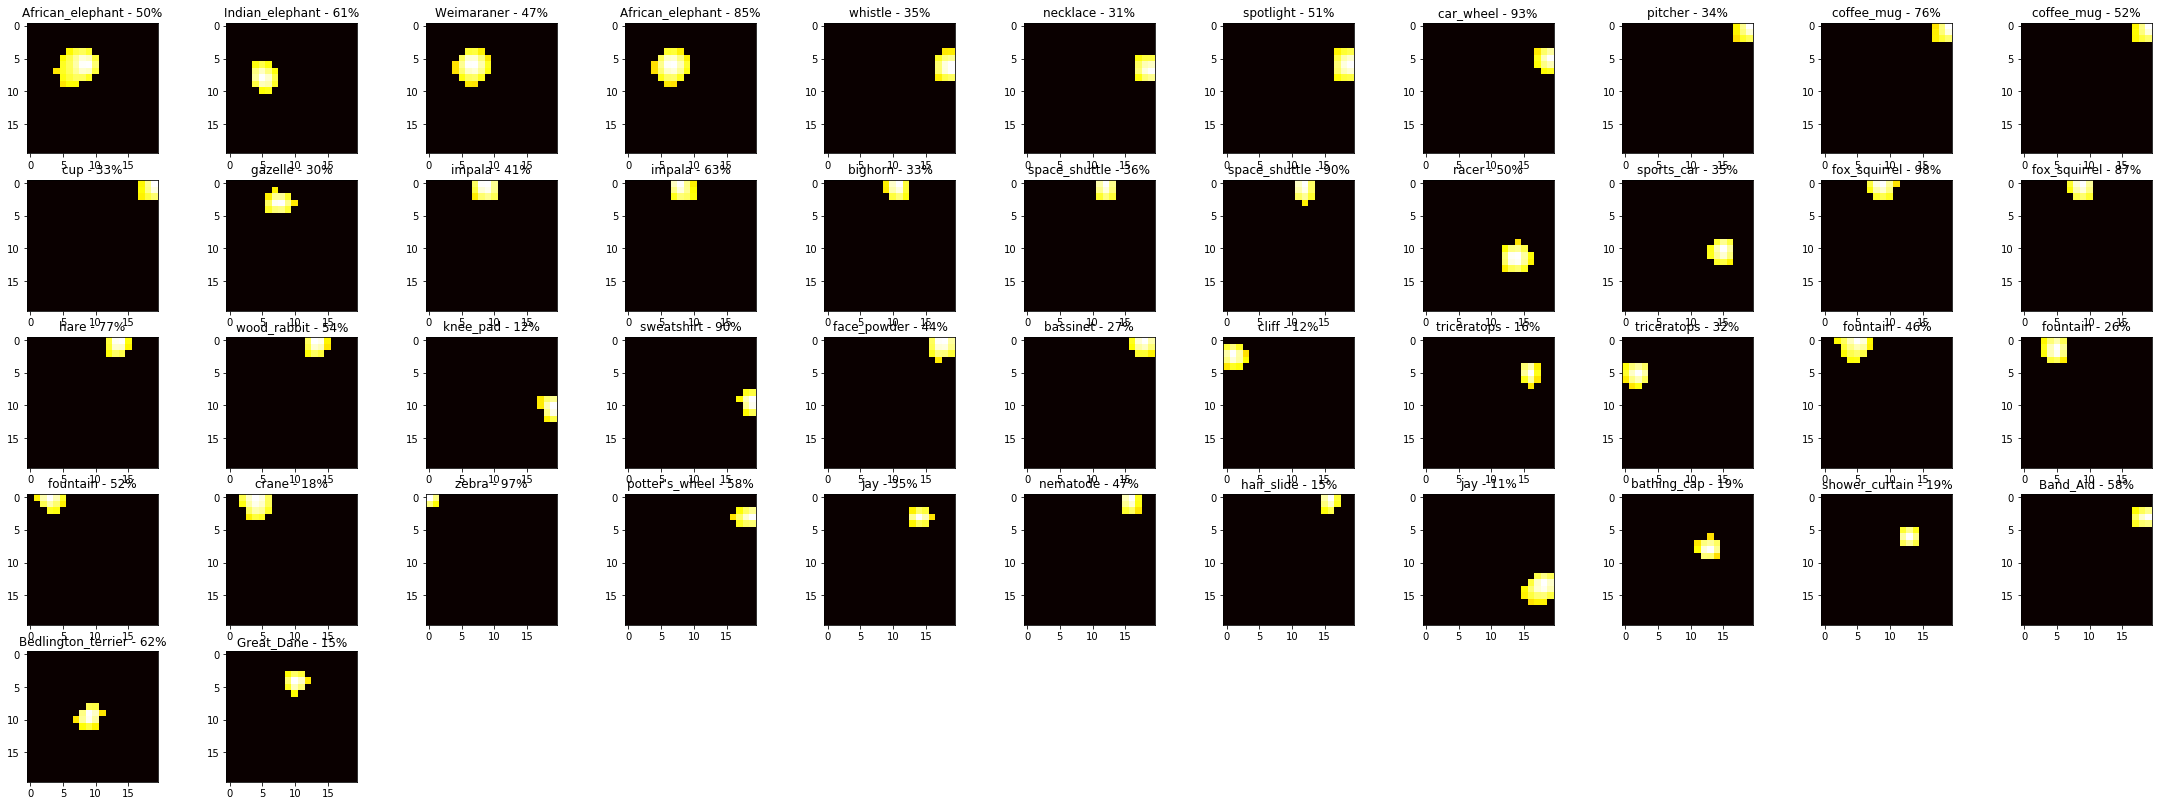

In [25]:
inp2_pre = []
for i in patterns_red:
    inp2_pre.append(i.reshape((len(i)*len(i[0]))))
inp2_pre_size = len(i)*len(i[0])
print(inp2_pre_size)

dim = 20
inp2_som = MiniSom(dim, dim, inp2_pre_size, sigma=2.5, learning_rate=0.05)
inp2_som.train(inp2_pre, 1000)

inp2 = []
for aux in inp2_pre:
    inp2.append(inp2_som.activate(aux))

for i in range(len(inp2)):
    f_min, f_max = np.amin(inp2[i]), np.amax(inp2[i])
    inp2[i] = (inp2[i] - f_min) / (f_max - f_min)
    inp2[i] = 1-inp2[i]
   
    for j in range(dim):
        for k in range(dim):
            if(inp2[i][j][k] < 0.7): inp2[i][j][k] = 0
                

print(dim*dim) 
printPatterns(inp2, tittles, prob)

In [15]:
inp_1 = locations
inp_2 = inp2
for i in range(len(inp_1)):
    inp_1[i] = inp_1[i].reshape((inp_1[i].shape[0]*inp_1[i].shape[1]))
    
for i in range(len(inp_2)):
    inp_2[i] = inp_2[i].reshape((inp_2[i].shape[0]*inp_2[i].shape[1]))

In [16]:
inp_final = []
for i in range(len(inp_1)):
    inp_final.append(np.concatenate((inp_1[i], inp_2[i])))

900


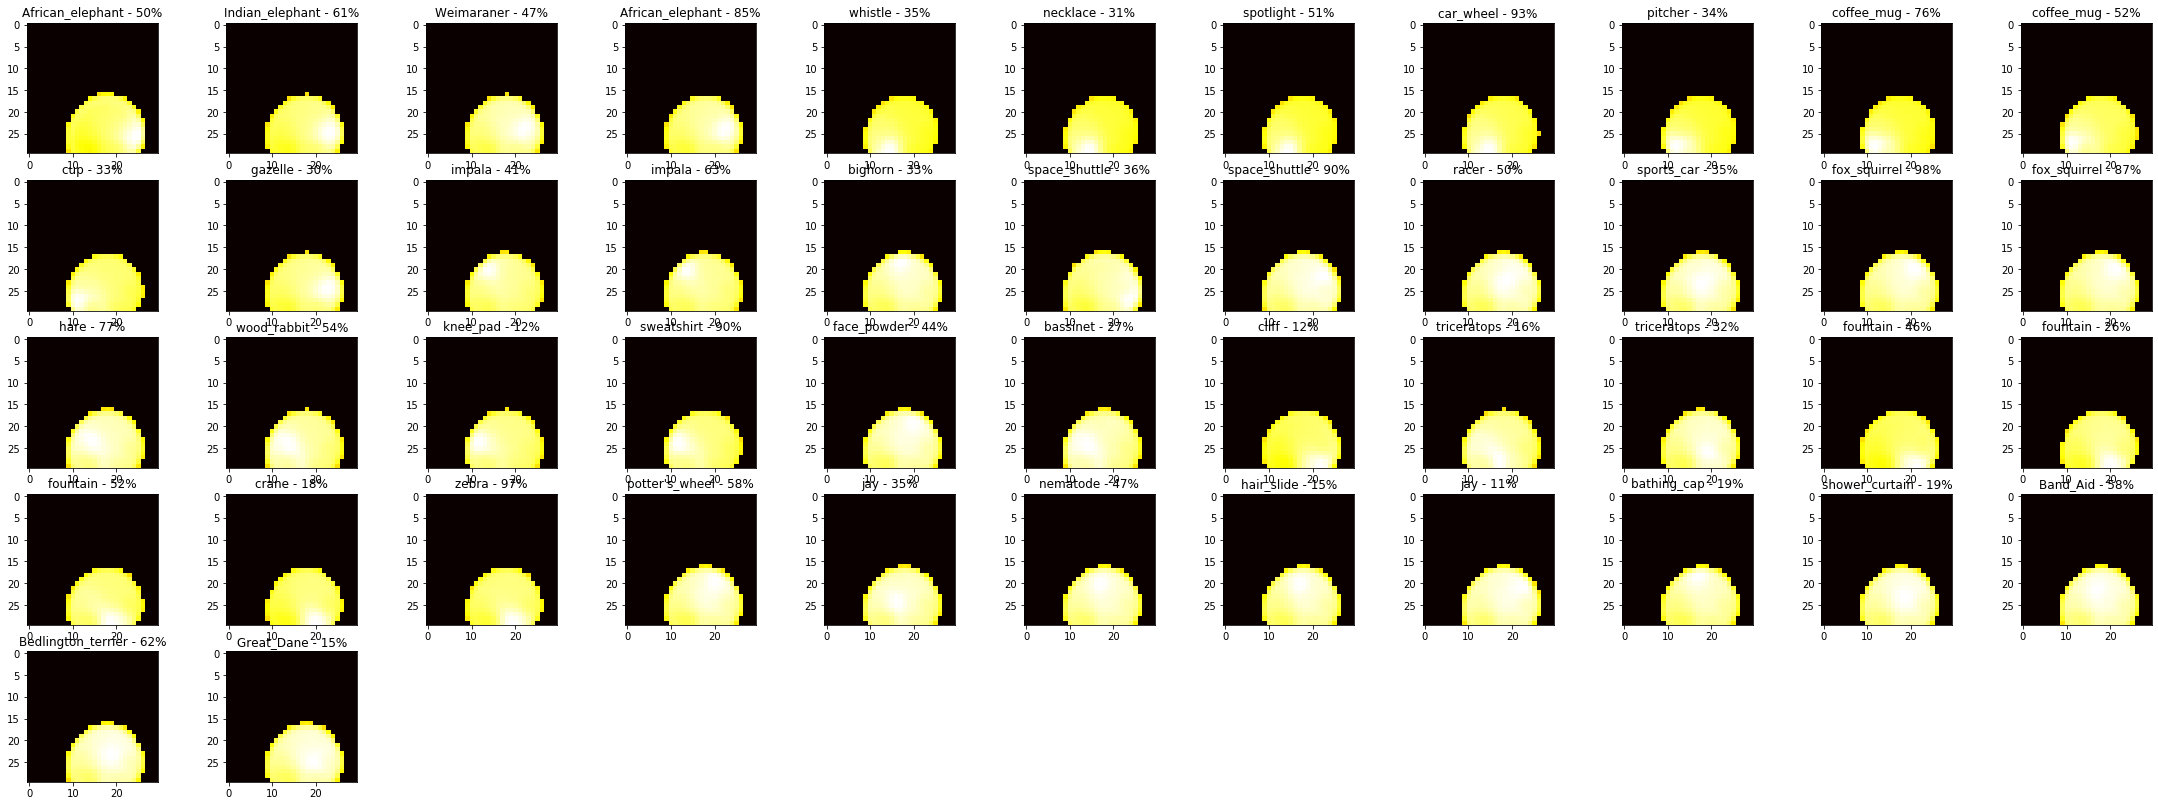

In [17]:
dim = 30
final_som = MiniSom(dim, dim, inp_final[0].shape[0], sigma=2.5, learning_rate=0.05)
final_som.train(inp_final, 800)

final = []
for aux in inp_final:
    final.append(final_som.activate(aux))

for i in range(len(final)):
    f_min, f_max = np.amin(final[i]), np.amax(final[i])
    final[i] = (final[i] - f_min) / (f_max - f_min)
    final[i] = 1-final[i]
   
    for j in range(dim):
        for k in range(dim):
            if(final[i][j][k] < 0.7): final[i][j][k] = 0
                

print(dim*dim) 
printPatterns(final, tittles, prob)